This file contains python code to 
test whether sel_idx can only like [1,2, 3] or it can take [0 2, 3] to penalize 1 only


In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [3]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [4]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_sinica_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from scenarios.simu_linear_sinica0 import settings
from hdf_utils.fns_sinica import  fourier_basis_fn

from joblib import Parallel, delayed

In [5]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Params

In [78]:
np.random.seed(0)
c = 0.0

setting = settings.cmpn0s1
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)
x = np.linspace(0, 1, data_gen_params.npts)

#setting.sel_idx = np.concatenate([[1], np.arange(4, 200)])
setting.sel_idx = np.concatenate([np.arange(1, 200)])
#setting.sel_idx = np.concatenate([[1], np.arange(3, 98), np.arange(100, 200)])


num_rep = 200
Cmat = np.eye(data_gen_params.d - len(setting.sel_idx))

array([[1.]])

## Simulation

In [84]:
def _run_fn(seed, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    x = np.linspace(0, 1, data_gen_params.npts)
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if True:
        cur_data = gen_simu_sinica_dataset(n=data_gen_params.n, 
                                   d=data_gen_params.d, 
                                   q=data_gen_params.q, 
                                   types_=data_gen_params.types_, 
                                   gt_alp=data_gen_params.gt_alp, 
                                   gt_beta=data_gen_params.gt_beta, 
                                   x=x,
                                   data_type=data_gen_params.data_type,
                                   data_params=data_gen_params.data_params, 
                                   seed=seed, 
                                   verbose=verbose);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
        
    return hdf_fit


### single test

In [85]:
seed = 1
lam = 1.3
N = 4

res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, is_save=False, verbose=2)

2024-03-04 10:48:23,170 - optimization.opt - INFO - opt params is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 1, 'R': 200000.0, 'linear_theta_update': 'cholesky_inv'}.
2024-03-04 10:48:23,171 - optimization.opt - INFO - SIS params is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2, 'SIS_ws': 'simpson'}.
2024-03-04 10:48:23,172 - optimization.opt - INFO - model params is {'norminal_sigma2': 1, 'ws': 'simpson'}.
2024-03-04 10:48:23,172 - optimization.opt - INFO - penalty params is {'a': 3.7, 'lam': 1.3}.
2024-03-04 10:48:23,173 - optimization.opt - INFO - bspline params is {'basis_ord': 4, 'is_orth_basis': True, 'N': 4}.
2024-03-04 10:48:23,173 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
Main Loop:   6%|████▉                                                                                  | 113/2000 [00:00<00:02, 638.05it/s, error=0.000575, GamL0=6, CV=0.0005]


In [86]:
torch.norm(res.est_Gam, dim=0)

tensor([0.0951, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1693, 0.0000, 0.0395, 0.0000, 0.0000, 0.0413, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0082, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.6439])

In [87]:
res.keep_idxs

array([  0,   3,   4,   6,  11,  12,  15,  18,  29,  30,  38,  42,  43,
        44,  50,  56,  62,  64,  68,  80,  81,  88,  90,  91,  92, 101,
       108, 110, 118, 119, 121, 125, 154, 157, 158, 172, 173, 186, 194,
       198, 199])

In [88]:
res.hypo_test(Cmat, ts=None)

2024-03-04 10:48:25,860 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


{'pval': 0.9670112930956261, 'T_v': tensor(0.5637)}

In [83]:
res.hypo_test(Cmat, ts=None)

2024-03-04 10:48:07,488 - optimization.opt - INFO - hypo params is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


{'pval': 0.9670112930956261, 'T_v': tensor(0.5637)}

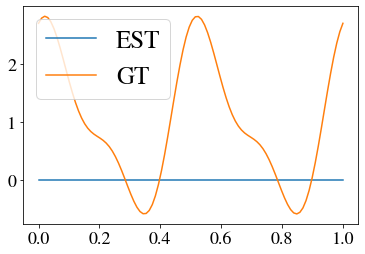

In [73]:
est_beta = res.basis_mat @ res.est_Gam
gt_beta = setting.data_gen_params.gt_beta[:, res.keep_idxs]
idx = -1
plt.plot(np.linspace(0, 1, len(est_beta)), est_beta[:, idx], label="EST")
plt.plot(np.linspace(0, 1, len(gt_beta)), gt_beta[:, idx], label="GT")
plt.legend()

### Multipe test

In [16]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [17]:
seed = 6
N = 4
lam = 1.0

setting.opt_params.beta = 1 
setting.data_gen_params.npts = 100
def _run_fn1(seed):
    res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res.hypo_test(Cmat, ts=None, is_simpler=False)
    test_res = edict()
    test_res.update(res.hypo_test_res)
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.iters = res.conv_iter
    return test_res
    
num_rep = 100
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    

100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 30.66it/s]


The size is 0.040 and the mean of Tv is 3.844 and thoeretically it is 4. L0 is 7.88.
1.0


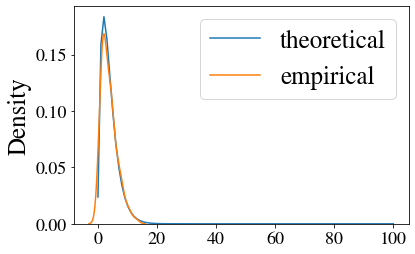

In [18]:
pvals = np.array([res.pval for res in test_ress])
T_vs = np.array([res.T_v for res in test_ress]);
L0s = np.array([res.L0 for res in test_ress]);
chi_df = Cmat.shape[0]*N
kpidx = outlier_det(T_vs, 0.00)
print(
    f"The size is {np.mean(pvals[kpidx]<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs[kpidx]):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s[kpidx]):.2f}."
     )

print(np.mean(kpidx))
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs[kpidx], label="empirical")
plt.legend()